# 뉴스 토픽 분류하기  
- 양방향 LSTM 활용
---

## [1] 데이터 불러오기
---

In [391]:
# 모듈 불러오기
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
# sklearn
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
# tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
# nlp
from konlpy.tag import Kkma, Komoran, Okt
from nltk.corpus import stopwords
import nltk as nlp

In [392]:
data = pd.read_csv('C:/Users/USER/Downloads/open/train_data.csv')
topic = pd.read_csv('C:/Users/USER/Downloads/open/topic_dict.csv')

## [2] 데이터 전처리
---

### [2-1] 결측치 확인

In [393]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45654 entries, 0 to 45653
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      45654 non-null  int64 
 1   title      45654 non-null  object
 2   topic_idx  45654 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


In [394]:
data.isna().sum()

index        0
title        0
topic_idx    0
dtype: int64

In [395]:
data.head()

index                             title  topic_idx
0      0          인천→핀란드 항공기 결항…휴가철 여행객 분통          4
1      1    실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화          4
2      2    이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것          4
3      3  NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합          4
4      4         시진핑 트럼프에 중미 무역협상 조속 타결 희망          4

In [396]:
data = data.iloc[:,1:]
data.head()

title  topic_idx
0          인천→핀란드 항공기 결항…휴가철 여행객 분통          4
1    실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화          4
2    이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것          4
3  NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합          4
4         시진핑 트럼프에 중미 무역협상 조속 타결 희망          4

In [399]:
data.topic_idx.value_counts(dropna=False)

4    7629
2    7362
5    6933
6    6751
1    6222
3    5933
0    4824
Name: topic_idx, dtype: int64

In [402]:
data.topic_idx.unique()

array([4, 6, 5, 0, 1, 3, 2], dtype=int64)

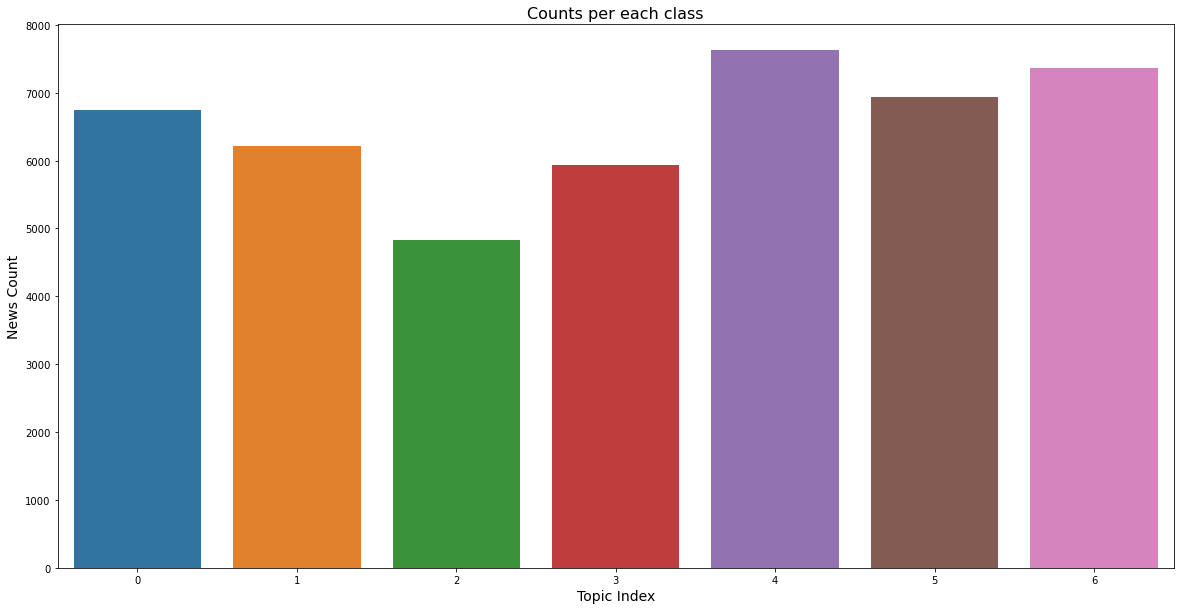

In [407]:
plt.figure(figsize = (20,10))
sns.barplot(x = data.topic_idx.unique(), y = data.topic_idx.value_counts(dropna=False))
plt.title("Counts per each class", fontdict = {"fontsize" : 16})
plt.xlabel("Topic Index", fontdict = {"fontsize" : 14})
plt.ylabel("News Count", fontdict = {"fontsize" : 14})
plt.xticks(rotation=360);

### [2-2] Preprocessing

In [408]:
stopwords_01 = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [409]:
data['title'][0]

'인천→핀란드 항공기 결항…휴가철 여행객 분통'

In [410]:
okt = Okt()

In [411]:
text_list = []
for text in tqdm(data['title']):
    text = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", " ", text) # 특수문자 제거
    text = text.strip() # 문자 처음과 끝 공백 제거
    tokens = okt.morphs(text) # 단어 추출
    text = [word for word in text if not word in stopwords_01] # 불용어 처리
    text = "".join(text)
    #text = text.replace(' ','')
    text_list.append(text) 

100%|███████████████████████████████████████████████████████████████████████████| 45654/45654 [01:44<00:00, 435.48it/s]


In [413]:
print(len(text_list))
print(text_list)

45654
['인천 핀란드 항공기 결항 휴철 여행객 분통', '실리콘밸리 넘어서겠다 구글 15조원 여  전역 거점화', '란 외무 긴장완화 해결책 미국 경제전쟁 멈추 것', 'NYT 클린턴 측근 기업 특수관계 조명 공 사 맞물려종합', '시진핑 트럼프 중미 무역협상 조속 타결 희망', '팔레스타인 지구서 16세 소년 스라엘군 총격 사망', '인 48년 만 파키스탄 공습 테러 캠프 폭격종합2보', '대선 TV토론 음담패설 만회실패 트럼프 사 대신 빌클린턴 공격해 역효', '푸틴 반 상황 진전 위 방안 김정 위원장 논', '특검 면죄부 받 트럼프 스캔 보 언론 맹공 국민 적', '오키나서 열린 강제징용 노동 추식', '란서 최고지 모욕 혐 미국인 징역 10년 선고', '카니발 축제 보러  브라질 리우 대형 유람선 행렬', '올랜 병원 최악 총기 테러 부상 치료비 안 받다', '대기업 올해 평균 2 46  임금 인상', 'WMO 엘니뇨 여전히 강력 2분기엔 소멸될 듯', '스라엘 네타냐후 유대교 병역문제로 연정 협상 진통', 'UAE 사우디 어   호르무즈 호위 연합 참여키로', '사우디군 오만해 유조선 공격 예멘반군 연결 란 겨냥', '개천서 용 나라  사업 모교 1천억원 장학금 기부', 'EU 브렉시트 합 전 해야 할 일 많아   경고', '스팍스운용 일본 디플레 벗어나 새로운 약 준비 중', '트럼프 총기난사   공격 총기규제 초당적 협력 촉구종합', 'NBA 카지노업체 스폰서 계약  프로스포츠 사상 처음', '오바마 대통령 퇴임 후 워싱턴DC 사무실 개소 예정', '전문 트럼프 정부 북 정상급 관계 시할 것', '스라엘 네타냐후 란 경고 우리 전투기 달능 지역', '스라엘 네타냐후 총선 달 앞두고 우크라 방문 예정', '트럼프 탄핵보고서 통화기록 등장 문 숫 1', '미국 산업생산 달만 0 1   제조업 회복 기대', '셰크 살만 AFC 회장 평양 방문 최휘 국체육지위원장', '신중국70년  차나 미라클 최빈국서 G2 경제대국 부상', 'UAE 단교 20개월

In [414]:
data["title"] = text_list 
data.title

0                 인천 핀란드 항공기 결항 휴철 여행객 분통
1           실리콘밸리 넘어서겠다 구글 15조원 여  전역 거점화
2              란 외무 긴장완화 해결책 미국 경제전쟁 멈추 것
3         NYT 클린턴 측근 기업 특수관계 조명 공 사 맞물려종합
4                시진핑 트럼프 중미 무역협상 조속 타결 희망
                       ...               
45649         KB금융 미국 IB 스티펠 제휴 선진국 시장 공략
45650      1보 서울시교육청 신종코로나 확산 개학 연기 휴업 검토
45651          게시판 키움증권 2020 키움 영웅전 실전투대회
45652                    답변하 배기동 국립중앙박물관장
45653    2020 국인터넷기상 시상식 내달 1일 개최 특별상 김성후
Name: title, Length: 45654, dtype: object

In [415]:
# 단어 개수 column 추가
data['word_counts'] = [len(i.split(' ')) for i in data["title"]]
data['word_counts'].max()

15

In [416]:
# 최대 단어 개수
sent_length = data['word_counts'].max()

In [417]:
data['topic_idx'].value_counts(dropna=False)

4    7629
2    7362
5    6933
6    6751
1    6222
3    5933
0    4824
Name: topic_idx, dtype: int64

In [418]:
# Under Sampling
data=data.dropna()

data0 = data[data["topic_idx"] == 0]
data1 = data[data["topic_idx"]== 1][:4824]
data2 = data[data["topic_idx"]== 2][:4824]
data3 = data[data["topic_idx"]== 3][:4824]
data4 = data[data["topic_idx"]== 4][:4824]
data5 = data[data["topic_idx"]== 5][:4824]
data6 = data[data["topic_idx"]== 6][:4824]
data = pd.concat([data0, data1, data2, data3, data4, data5, data6], axis = 0)
data.head()

title  topic_idx  word_counts
617         지카바러스 규명 초저온전현미경 신약연구 유용          0            5
622      증강현실   알파고 어 포켓몬 고 거센 IT 광풍          0           10
643                  AI 월드컵 생생 현장 중계          0            5
654    세돌 알파고 집중력 사람 기긴 어렵다 일문일답종합2보          0            7
660  올해 휴대폰 국내 생산량 2천500만대 10년전 18 4          0            8

In [419]:
data.tail()

title  topic_idx  word_counts
29361    총선 D8   신공항공세 차단 더민주 서부산 공략 강화          6           10
29366      더민주 제주 경선 끝날 때까지 위원장 직무대행 체제          6            8
29376     비대위 첫날 쓴소리 봇물 국민 뜻대로 다 바꾸겠습니다          6            8
29379  문대통령 국정지지 45 로 1 p 상승 부정평 44 국갤럽          6           10
29404                나경원 관훈클럽 초청 토론회 참석          6            5

In [420]:
data = data.reset_index(drop=True)
data.head()

title  topic_idx  word_counts
0         지카바러스 규명 초저온전현미경 신약연구 유용          0            5
1      증강현실   알파고 어 포켓몬 고 거센 IT 광풍          0           10
2                  AI 월드컵 생생 현장 중계          0            5
3    세돌 알파고 집중력 사람 기긴 어렵다 일문일답종합2보          0            7
4  올해 휴대폰 국내 생산량 2천500만대 10년전 18 4          0            8

In [421]:
finalData = data['title']
finalData.head()

0           지카바러스 규명 초저온전현미경 신약연구 유용
1        증강현실   알파고 어 포켓몬 고 거센 IT 광풍
2                    AI 월드컵 생생 현장 중계
3      세돌 알파고 집중력 사람 기긴 어렵다 일문일답종합2보
4    올해 휴대폰 국내 생산량 2천500만대 10년전 18 4
Name: title, dtype: object

In [424]:
# target data 생성
target = data['topic_idx']

In [425]:
target.value_counts()

0    4824
1    4824
2    4824
3    4824
4    4824
5    4824
6    4824
Name: topic_idx, dtype: int64

In [426]:
finalData.shape, target.shape

((33768,), (33768,))

### [2-3] Tokenization

In [427]:
corpus = []
for i in finalData:
    corpus.append(i)

In [428]:
corpus

['지카바러스 규명 초저온전현미경 신약연구 유용',
 '증강현실   알파고 어 포켓몬 고 거센 IT 광풍',
 'AI 월드컵 생생 현장 중계',
 '세돌 알파고 집중력 사람 기긴 어렵다 일문일답종합2보',
 '올해 휴대폰 국내 생산량 2천500만대 10년전 18 4',
 'LG 갤노트8 겨냥 V30 티저 광고 2편으로 선전포고',
 'KT스카라프 알뜰폰 판매 전용 요금제 6종 출시',
 '안 쓰 TV 주파수 농어촌 무선인터넷 쓴다',
 '학을 즐기세요 4월 학 달 행사 100여건 풍성',
 '기정통부 실험실 창업 사업공모 총 93억원 규모',
 '삼성전 5G 기술로 MWC 공식방송 단독 생중계',
 '더 강력해진 알파고 인간 직관 모방해 학습',
 '어디서든 파티  LG G7 씽큐 붐박스 스피커 눈길',
 'KT 4년 만 영업익 4천억 돌파  깜짝 실적종합2보',
 '인공지능 박지성 나올까 KAIST서 세계 첫 AI월드컵',
 '5G 만난 스마트 카 MWC서 흥행몰 어질까',
 'LG G8X 듀얼 스크린 브라질 출시 중남미 공략 속',
 '인터넷진흥원 우수 정보보호 기술 지정제 시행',
 'SKT MWC서 20Gbps 속 5G 선보여 첫 공공장소 시연',
 '중온속기 라온 핵심장치 성능시험 성공 세계 8번째',
 'LG전 풀비전 로고 상표 출원 광고 활용',
 '네버 뉴스 100  AI 편집 부당 사람 할 부분 있어종합',
 '인터넷 업계 구글 반독점 위반 재조사해야',
 '중국산 모바일 게임 공습 대작으로 국내 시장 노린다',
 '네버 지 애플 카플레 지원 개시',
 '별 죽음 지구날씨 영향 끼친다',
 '학기술 현장규제 점검단 출범식',
 '네버 주소록 암호잠금 기능 입',
 '내년 학기술 분야 출연연 예산 4조8천712억원 4 2',
 '갤노트8 호주 인서 22일 출시 10월까지 150여국 확대',
 'LG G7 씽큐 사전예약 시작 공시지원금 최대 24만7천원',
 '구글 AI 진화 어디까지 당신 얼굴 알아보고 일정 알려준다종합',
 '어비 플래시 202

In [429]:
tokenizer = Tokenizer(num_words=8000)  
tokenizer.fit_on_texts(corpus)

In [430]:
len(tokenizer.word_counts)

56588

In [431]:
print(tokenizer.word_index)

{'대통령': 1, '첫': 2, '출시': 3, '게시판': 4, '등': 5, '신간': 6, '국': 7, 'kt': 8, '감독': 9, '개발': 10, '란': 11, '것': 12, '5g': 13, '전': 14, '트럼프': 15, '만': 16, '올해': 17, '삼성': 18, '개최': 19, '정부': 20, '네버': 21, 'lg': 22, '영업익': 23, '중': 24, '공개': 25, '작년': 26, '속': 27, '문': 28, '김정': 29, 'ai': 30, '더': 31, 'skt': 32, '후': 33, '국내': 34, '중국': 35, '서울': 36, '최대': 37, '미국': 38, '1': 39, '전국': 40, '1위': 41, '류현진': 42, '그래픽': 43, '최고': 44, '새': 45, '서비스': 46, '북': 47, '월드컵': 48, '세계': 49, '입': 50, '내년': 51, '5': 52, '코스피': 53, '2': 54, '사망': 55, '스마트폰': 56, '경기': 57, '총리': 58, '시즌': 59, '개막': 60, '시': 61, '추진': 62, '증': 63, '연속': 64, '주': 65, '주말': 66, '3': 67, '특징주': 68, '또': 69, '여행': 70, '능성': 71, '지원': 72, '논란': 73, '수': 74, '달': 75, '꺾고': 76, 'sk': 77, '듯': 78, '결정': 79, '터키': 80, '삼성전': 81, '내': 82, 'mlb': 83, '비': 84, '내일': 85, '돌파': 86, '손흥민': 87, '확대': 88, '4': 89, '오늘': 90, '방문': 91, '규모': 92, '내달': 93, '후보': 94, '안': 95, '미': 96, '강화': 97, '프로농구': 98, '장': 99, '기술': 100, '상': 101, '6': 102, '

In [432]:
tokenizer.word_counts.items()

odict_items([('지카바러스', 5), ('규명', 33), ('초저온전현미경', 1), ('신약연구', 1), ('유용', 9), ('증강현실', 12), ('알파고', 53), ('어', 100), ('포켓몬', 12), ('고', 63), ('거센', 12), ('it', 28), ('광풍', 1), ('ai', 279), ('월드컵', 249), ('생생', 6), ('현장', 51), ('중계', 19), ('세돌', 17), ('집중력', 5), ('사람', 80), ('기긴', 1), ('어렵다', 9), ('일문일답종합2보', 1), ('올해', 391), ('휴대폰', 20), ('국내', 275), ('생산량', 6), ('2천500만대', 1), ('10년전', 1), ('18', 59), ('4', 183), ('lg', 323), ('갤노트8', 49), ('겨냥', 41), ('v30', 56), ('티저', 4), ('광고', 55), ('2편으로', 1), ('선전포고', 3), ('kt스카라프', 7), ('알뜰폰', 61), ('판매', 136), ('전용', 36), ('요금제', 57), ('6종', 5), ('출시', 678), ('안', 180), ('쓰', 15), ('tv', 53), ('주파수', 25), ('농어촌', 3), ('무선인터넷', 3), ('쓴다', 22), ('학을', 1), ('즐기세요', 10), ('4월', 72), ('학', 62), ('달', 199), ('행사', 109), ('100여건', 4), ('풍성', 43), ('기정통부', 44), ('실험실', 5), ('창업', 24), ('사업공모', 1), ('총', 36), ('93억원', 3), ('규모', 181), ('삼성전', 189), ('5g', 443), ('기술로', 26), ('mwc', 48), ('공식방송', 1), ('단독', 79), ('생중계', 38), ('더', 278), ('강력해진', 2), (

In [1]:
# 희귀 단어 빈도수 
def checkToken(tokenizer, threshold) :
    total_cnt = len(tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value
    

    total = (rare_freq / total_freq)*100

    print('단어 집합(vocabulary)의 크기 :',total_cnt)
    print('등장 빈도가 %s번 미만인 희귀 단어의 수: %s'%(threshold, rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    return (rare_freq / total_freq) * 100

In [434]:
checkToken(tokenizer, 5)

단어 집합(vocabulary)의 크기 : 56588
등장 빈도가 5번 미만인 희귀 단어의 수: 48590
단어 집합에서 희귀 단어의 비율: 85.86626139817629
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 29.3512227407153


29.3512227407153